In [1]:
!nvidia-smi

Wed Jan 30 07:06:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    81W / 149W |      0MiB / 11441MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import sys
from functools import wraps

sys.path.append('..')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from radial.batchflow import Dataset, FilesIndex, Pipeline, action, inbatch_parallel, B, V, C, ImagesBatch, DatasetIndex, Batch
import radial.batchflow as ds
from radial.batchflow.models.tf import TFModel, VGG7, ResNet18
from radial import RadialBatch, RadialImagesBatch

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# plt.style.use('dark_background')

In [5]:
# import random

# class TmpBatch(ImagesBatch, RadialBatch):
#     @property
#     def components(self):
#         """tuple of str: Data components names."""
#         return "time", "derivative", "rig_type", "target", "predictions", "images"

# #     @action
# #     def expand_dims(self, components=None):
# #         setattr(self, components, getattr(self, components).reshape((-1, 1)).astype(np.float32))
# #         return self
    
#     @action
#     def load(self, fmt=None, components=None, *args, **kwargs):
#         components = [components] if isinstance(components, str) else components

#         if fmt == 'npz' or fmt == 'csv':
# #             print('here')
#             RadialBatch.load(self, fmt=fmt, components=components, *args, **kwargs)
#         elif fmt == 'image':
#             ImagesBatch.load(self, fmt=fmt, components=components, *args, **kwargs)
# #         else:
# #             Batch.load(self, fmt=fmt, components=components, *args, **kwargs)
#         return self



In [6]:
train_index = FilesIndex(path='january/train_npz/*.npz', no_ext=True)
train_set = Dataset(train_index, batch_class=RadialImagesBatch)

test_index = FilesIndex(path='january/npz_with_predictions/*.npz', no_ext=True)
test_set = Dataset(train_index, batch_class=RadialImagesBatch)

In [7]:
IMAGE_DIR = 'bold_data/*.png'

In [8]:
image_index = FilesIndex(path=IMAGE_DIR, no_ext=True)

In [9]:
def log(*args):
    return np.array(list(map(np.log10, args)))

In [10]:
# train_index = FilesIndex(path='january/bw_train/*.png', no_ext=True)
# train_set = Dataset(train_index, batch_class=TmpBatch)


In [11]:
load_ppl = (Pipeline()
                .load(fmt='npz')
                .drop_negative()
                .apply_transform(log, src=['time', 'derivative', 'target'], dst=['log_time', 'log_derivative', 'log_target'])
                .normalize(src=['log_time', 'log_derivative'], dst=['log_norm_time', 'log_norm_derivative'],\
                           dst_range=[None, 'derivative_range'])
                .normalize(src='log_target', dst='log_norm_target', src_range='derivative_range')
                .load(fmt='image', src=image_index, components='images')
                .resize((300, 200))
                .crop(origin='center', shape=(270, 180))
                .to_array()
                .multiply(1/255.)
                .load(fmt='csv', src='january/targets.csv', components='target', index_col='index')
                .expand_dims(src='log_norm_target')
                .expand_dims(src='target')
           )

In [12]:
btch = (load_ppl << train_set).next_batch(2)
btch.target

array([[0.56620593],
       [0.46064031]])

In [13]:
btch.log_norm_target

array([[0.5662059307050681],
       [0.4606403064353336]], dtype=object)

In [14]:
img = (load_ppl << train_set).next_batch(2).images

In [15]:
img[0].shape

(180, 270, 1)

In [16]:
(load_ppl << train_set).next_batch(2).target

array([[0.56620593],
       [0.46064031]])

In [17]:
ppl = load_ppl << train_set

In [18]:
btch = ppl.next_batch(2)

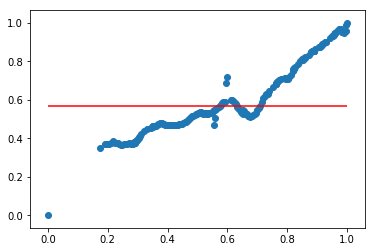

In [19]:
plt.scatter(btch.log_norm_time[0], btch.log_norm_derivative[0])
plt.hlines(btch.log_norm_target[0], 0, 1, color='r')

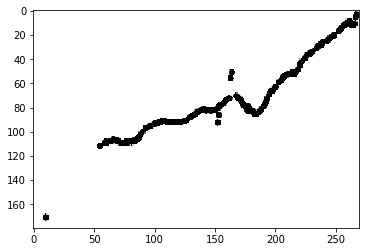

In [20]:
plt.imshow(btch.images[0, :, :, 0],  cmap="gray")
plt.show()

In [21]:
model_config = {
    'inputs': dict(images=dict(shape=B('image_shape')),
                             labels={'shape': (1), 'name': 'targets'}),
    'body': dict(layout='cpna cpna cpna cpna cpna cpna cpna', filters=[16, 16, 16, 32, 64, 128, 128],
                 strides=1, pool_strides=2, kernel_size=[22, 22, 11, 9, 7, 3, 3], dilation_rate=[2, 2, 1, 1, 1, 1, 1]),
    'head': dict(layout='Pf', units=1),
    'initial_block/inputs': 'images',
    'loss': 'mse',
    'optimizer': 'Adam'}
#     'optimizer': ('Momentum', {'use_nesterov': True, 'learning_rate': 0.01, 'momentum': 0.5})}

In [22]:
train_template = (Pipeline()
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_model('dynamic', TFModel, 'image_model', config=model_config)
                  .train_model('image_model', fetches='loss',
                               feed_dict={'images': B('images'),
                                          'labels': B('target')}, 
                               save_to=V('loss'), mode='w')
                  .update_variable('loss_history', V('loss'), mode='a'))

train_pipeline = (load_ppl + train_template) << train_set

test_template = (Pipeline()
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('loss_history', init_on_each_run=list)
                  .import_model('image_model', train_pipeline)
                  .predict_model('image_model', fetches=['loss', 'predictions'],
                               feed_dict={'images': B('images'),
                                          'labels': B('target')}, 
                               save_to=[V('loss'), B('predictions')], mode='w')
                  .update_variable('loss_history', V('loss'), mode='a')
                )

In [23]:
test_pipeline = (load_ppl + test_template) << test_set

In [24]:
train_pipeline.get_variable('loss_history')

In [25]:
# train_pipeline.reset_iter()    

In [26]:
# train_pipeline.next_batch(16, shuffle=True, n_epochs=10, drop_last=False, bar=True)
# train_pipeline.next_batch(16, shuffle=True, n_epochs=10, drop_last=False, bar=True)

# train_pipeline.next_batch(16, shuffle=True, n_epochs=10, drop_last=False, bar=True)
# train_pipeline.next_batch(16, shuffle=True, n_epochs=10, drop_last=False, bar=True)

In [27]:
(train_pipeline.get_variable('loss_history'))

In [28]:
# for i in tqdm(range(500)):
train_pipeline.run(16, shuffle=True, n_epochs=1, drop_last=False, bar=True)
test_pipeline.run(16, shuffle=True, n_epochs=1, drop_last=False, bar=True)

 95%|█████████▌| 19/20 [00:04<00:00,  4.05it/s]


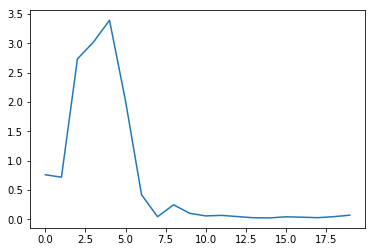

In [29]:
plt.plot((np.array(train_pipeline.get_variable('loss_history'))))

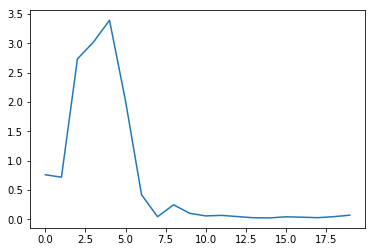

In [30]:
plt.plot((np.array(train_pipeline.get_variable('loss_history')))[-100:])

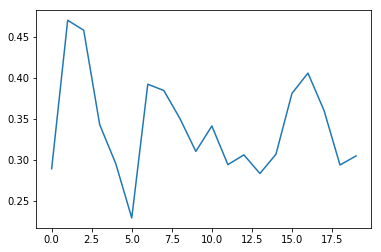

In [31]:
plt.plot((np.array(test_pipeline.get_variable('loss_history'))))

In [62]:
len(test_pipeline.get_variable('loss_history'))

584

In [33]:
test_pipeline.next_batch(10)

In [63]:
predict_pipeline = (Pipeline()
                        .denormalize(src='predictions', dst='denorm_predictions',
                                               src_range='derivative_range')
                   )

In [64]:
predict_pipeline = test_pipeline + predict_pipeline

In [65]:
btch = predict_pipeline.next_batch(len(test_set.indices), shuffle=True, n_epochs=None, drop_last=False, bar=True)



  0%|          | 0/9223372036854775807 [00:00<?, ?it/s]

In [66]:
# btch.denorm_predictions

In [67]:
metrics = np.abs(btch.denorm_predictions.reshape(-1) - btch.log_target.reshape(-1)) / btch.log_target.reshape(-1)
metrics = metrics.astype(np.float32)

In [68]:
np.mean(metrics)

0.109778486

In [69]:
np.percentile(metrics, q=90)

0.25779038667678833

(array([81., 66., 44., 37., 22., 20.,  7., 11.,  7.,  6.]),
 array([0.00084991, 0.03553661, 0.07022332, 0.10491002, 0.13959673,
        0.17428343, 0.20897014, 0.24365684, 0.27834355, 0.31303025,
        0.34771696]),
 <a list of 10 Patch objects>)

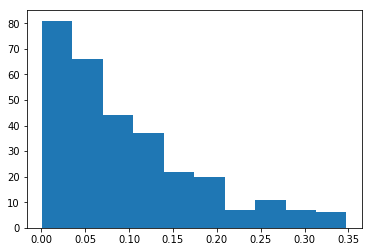

In [70]:
plt.hist(np.sort(metrics)[:-10])

(array([3., 1., 0., 2., 1., 0., 0., 1., 1., 1.]),
 array([0.39061502, 0.42163896, 0.4526629 , 0.48368684, 0.51471078,
        0.54573472, 0.57675866, 0.6077826 , 0.63880654, 0.66983048,
        0.70085442]),
 <a list of 10 Patch objects>)

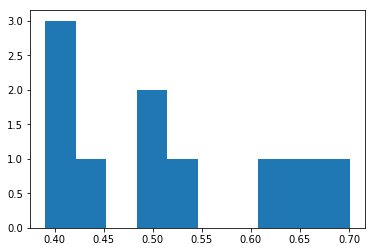

In [71]:
plt.hist(np.sort(metrics)[-10:])

In [72]:
np.mean(metrics < 0.3)*100

93.56913183279742

Well that is not quite stable

In [93]:
np.mean(metrics < 0.3)*100

69.45337620578779

In [49]:
np.mean(metrics < 0.3)*100

90.9967845659164

    'body': dict(layout='cpna cpna cpna cpna cpna cpna cpna', filters=[16, 16, 16, 32, 64, 128, 128],
                 strides=1, pool_strides=2, kernel_size=[22, 22, 11, 9, 7, 3, 3], dilation_rate=[2, 2, 1, 1, 1, 1, 1]),


In [41]:
np.mean(metrics < 0.3)*100

81.9935691318328

best result so far 53.37 large_kernel_size, dilation_rate=1:

In [101]:
np.mean(metrics < 0.3)*100


53.37620578778135

In [105]:
np.mean(metrics < 0.3)*100


33.762057877813504

In [77]:
ix = np.argsort(metrics)

In [78]:
metrics[ix]

array([1.44679303e-04, 1.49443396e-04, 3.18469305e-04, 3.56872188e-04,
       3.73706687e-04, 3.91858543e-04, 4.85584314e-04, 5.31797821e-04,
       7.35672249e-04, 1.02308206e-03, 1.02318986e-03, 1.02630514e-03,
       1.08922750e-03, 1.25436357e-03, 1.36602402e-03, 1.42794068e-03,
       1.55274989e-03, 1.64531800e-03, 1.78255769e-03, 1.79392297e-03,
       1.96085195e-03, 2.00646394e-03, 2.04662560e-03, 2.11637118e-03,
       2.18123710e-03, 2.31928937e-03, 2.38665030e-03, 2.52047600e-03,
       2.52212561e-03, 2.57688412e-03, 2.79134349e-03, 2.89372751e-03,
       2.99748778e-03, 3.58217652e-03, 3.77475657e-03, 3.82977445e-03,
       3.83719895e-03, 3.87215614e-03, 4.08074819e-03, 4.12893062e-03,
       4.38760687e-03, 4.60888166e-03, 4.63429280e-03, 4.93269367e-03,
       5.00543742e-03, 5.05829602e-03, 5.19590080e-03, 5.30359941e-03,
       5.45764109e-03, 5.52074611e-03, 5.67780854e-03, 5.84768457e-03,
       5.86629659e-03, 6.05823798e-03, 6.46197656e-03, 6.67932909e-03,
      

Let's have a look at the worst predictions

target=[0.8488562], prediction=[0.9319013]


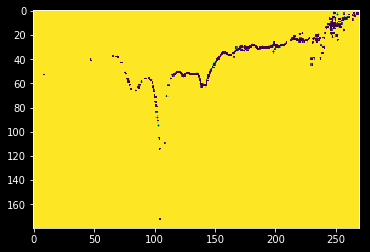

target=[0.7917688], prediction=[0.8729371]


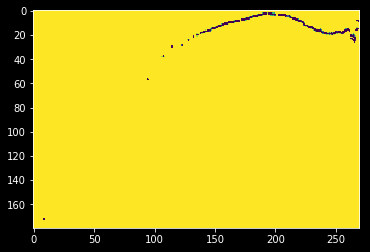

target=[0.6266361], prediction=[0.58833003]


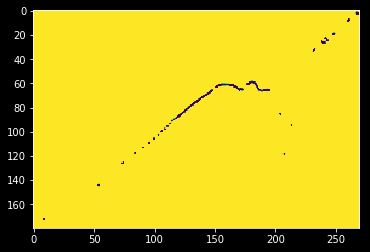

target=[0.67855746], prediction=[0.7088903]


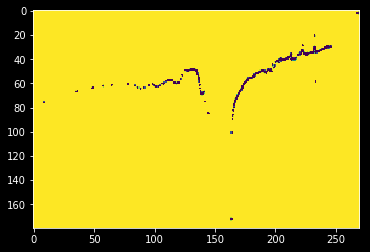

target=[0.48222452], prediction=[0.5679348]


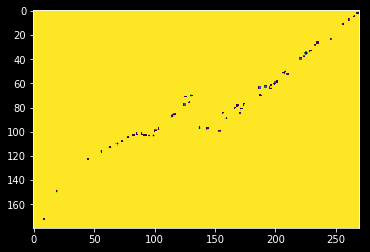

target=[0.5294573], prediction=[0.6078842]


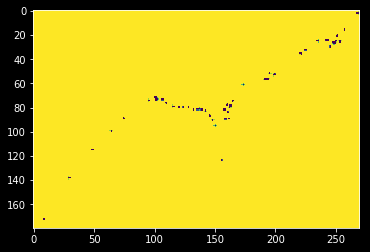

target=[0.6468173], prediction=[0.59895486]


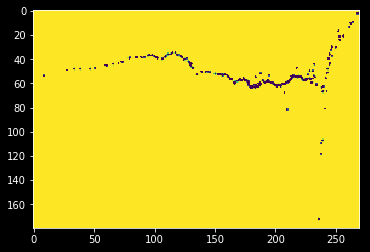

target=[0.6283737], prediction=[0.65578026]


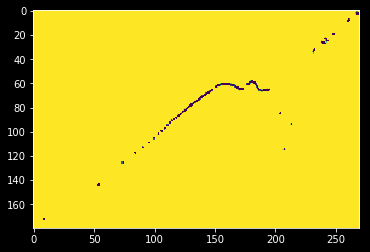

target=[0.9199043], prediction=[0.8371297]


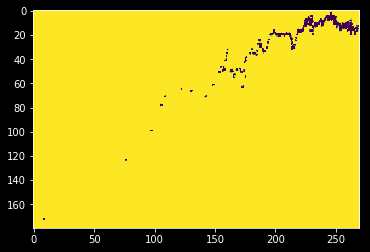

target=[0.42760912], prediction=[0.5165932]


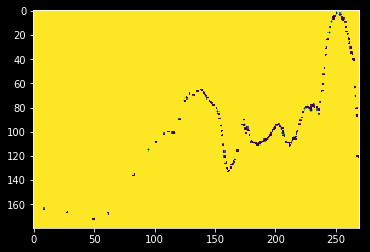

target=[0.97731096], prediction=[0.922285]


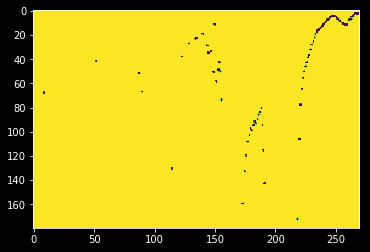

target=[0.33904198], prediction=[0.40476224]


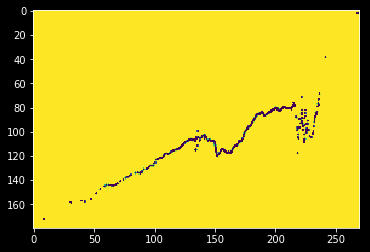

target=[0.3628638], prediction=[0.43202093]


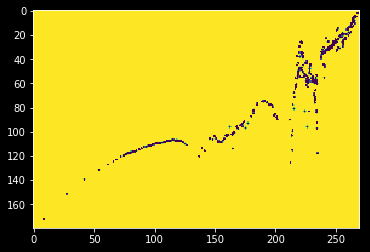

target=[0.69086295], prediction=[0.62541515]


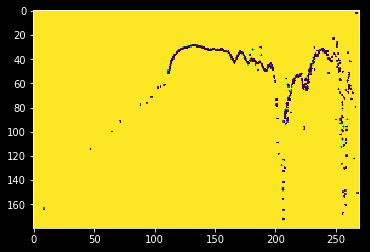

target=[1.0010998], prediction=[1.0508947]


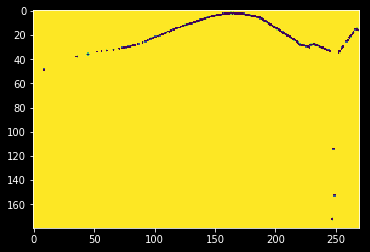

target=[0.62756807], prediction=[0.711203]


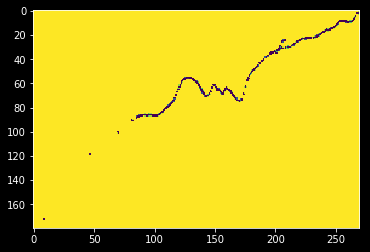

  0%|          | 1/9223372036854775807 [35:24<5443513892707109728:42:40, 2124.67s/it]

  0%|          | 1/9223372036854775807 [33:20<5126202562221820841:31:44, 2000.82s/it]

target=[0.5039754], prediction=[0.557402]


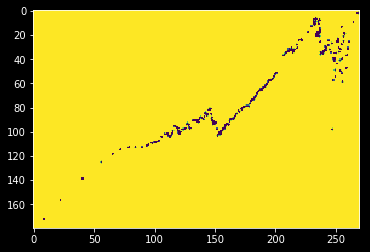

target=[0.7194286], prediction=[0.76545334]


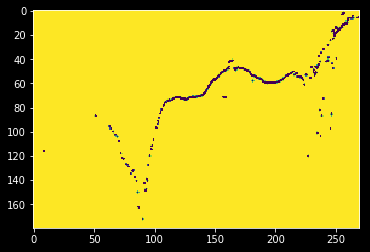

target=[0.4117558], prediction=[0.36075094]


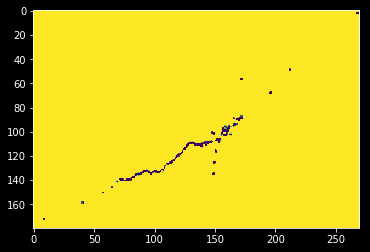

In [79]:
for i in range(1, 20):
    plt.imshow(btch.images[ix][-i, :, :, 0])
    print('target={}, prediction={}'.format(btch.target[ix][-i], btch.predictions[ix][-i]))
    plt.show()

In [43]:
train_pipeline.save_model('image_model', 'image_model_true_81')

# Train and test loss

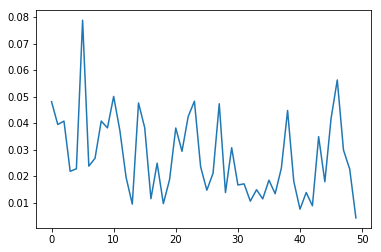

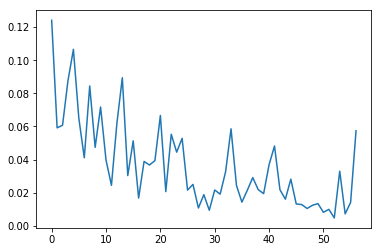

In [62]:
plt.plot(train_pipeline.get_variable('loss_history')[-50:])
plt.show()

plt.plot(test_pipeline.get_variable('loss_history'))
plt.show()

looks pretty much the same as the non-image models